In [1]:
import torch
import torchvision
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from multiscaleloss import *

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torchvision.__version__

'0.12.0'

In [3]:
data = torchvision.datasets.Sintel(".")

In [4]:
class TSintel(torchvision.datasets.Sintel):
    def __init__(self, root):
        super().__init__(root=root)
        
    def __getitem__(self, index):
        img1, img2, flow = super().__getitem__(index)
        img1 = torchvision.transforms.ToTensor()(img1)
        img2 = torchvision.transforms.ToTensor()(img2)
        return img1, img2, flow

In [5]:
Tdata = TSintel(".")

In [6]:
train_size = round(len(Tdata) * 0.8)
test_size = round(len(Tdata) * 0.2)

In [7]:
assert train_size + test_size == len(Tdata)

In [8]:
train_data, test_data = torch.utils.data.random_split(Tdata, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

In [10]:
from model import FlowNetS
from multiscaleloss import multiscaleEPE

/home/ubuntu/cs231n/util.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


In [11]:
train_params = {
    "epochs": 100,
    "lr": 1e-4,
    "weight_decay": 4e-4
}

dataloaders = {
    "train": train_loader,
    "val": test_loader,
}

In [12]:
def train_flownet(dataloaders, train_params):
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    
    epochs = train_params.get("epochs")
    lr = train_params.get("lr")
    weight_decay = train_params.get("weight_decay")
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = FlowNetS()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150, 200], gamma=0.5)

    
    losses = {
        "train": [],
        "val": []
    }
    
    model.train()
    for epoch in range(epochs):
    
        print("Epoch", str(epoch) + ": ", end="")
        train_loss = 0.0
        val_loss = 0.0
        
        model.train()
        for i, (img1, img2, label) in tqdm(enumerate(train_loader)):
            image = torch.cat((img1, img2), dim=1).to(device)
            label = label.to(device)
            train_loss += flownet_batch_train(model, optimizer, image, label)
            
        model.eval()
        with torch.no_grad():
            for i, (img1, img2, target) in enumerate(val_loader):
                image = torch.cat((img1, img2), dim=1).to(device)
                label = target.to(device)
                val_loss += flownet_batch_validate(model, image, label)
                
        val_loss /= len(val_loader)
        train_loss /= len(train_loader)

        print("Train Loss", train_loss, "Val Loss", val_loss)
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
            
    return model, losses

def flownet_batch_train(model, optimizer, image, label):
    optimizer.zero_grad()
    outputs = model(image)
    h, w = label.size()[-2:]
    outputs = [torch.nn.functional.interpolate(outputs[0], (h,w)), *outputs[1:]]

    loss = multiscaleEPE(outputs, label, sparse=False)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        train_loss = realEPE(outputs[0], label, sparse=False).item()
    return train_loss

def flownet_batch_validate(model, image, label):
    output = model(image)
    loss = realEPE(output, label, sparse=False)
    return loss.item()

In [13]:
model, flownet_losses = train_flownet(dataloaders, train_params)

Epoch 0: 

53it [01:51,  2.11s/it]


Train Loss 12.97269210275614 Val Loss 13.250021861149715
Epoch 1: 

53it [01:37,  1.84s/it]


Train Loss 12.908998017041188 Val Loss 12.426527720231276
Epoch 2: 

53it [01:39,  1.88s/it]


Train Loss 11.802306634075237 Val Loss 11.943709666912373
Epoch 3: 

53it [01:39,  1.88s/it]


Train Loss 11.224278926849365 Val Loss 11.379616040449877
Epoch 4: 

53it [01:39,  1.88s/it]


Train Loss 11.16837486231102 Val Loss 11.865288514357347
Epoch 5: 

53it [01:39,  1.87s/it]


Train Loss 10.844673588590801 Val Loss 11.599560480851393
Epoch 6: 

53it [01:39,  1.88s/it]


Train Loss 10.91467281557479 Val Loss 11.020053239969107
Epoch 7: 

53it [01:39,  1.88s/it]


Train Loss 11.909354137924483 Val Loss 11.6975553219135
Epoch 8: 

53it [01:39,  1.87s/it]


Train Loss 10.432114016334966 Val Loss 11.835327185117281
Epoch 9: 

53it [01:38,  1.87s/it]


Train Loss 10.308536740968812 Val Loss 11.139415704287016
Epoch 10: 

53it [01:38,  1.86s/it]


Train Loss 10.121979119642726 Val Loss 10.37154403099647
Epoch 11: 

53it [01:39,  1.87s/it]


Train Loss 9.948018262971122 Val Loss 10.64165214391855
Epoch 12: 

53it [01:38,  1.86s/it]


Train Loss 9.734707940299556 Val Loss 9.867791175842285
Epoch 13: 

53it [01:38,  1.86s/it]


Train Loss 9.603816284323639 Val Loss 11.342758288750282
Epoch 14: 

53it [01:39,  1.88s/it]


Train Loss 9.880284606285816 Val Loss 10.246934707348164
Epoch 15: 

53it [01:39,  1.88s/it]


Train Loss 9.73944283431431 Val Loss 12.18366762307974
Epoch 16: 

53it [01:39,  1.88s/it]


Train Loss 9.334015706800065 Val Loss 10.169215752528263
Epoch 17: 

53it [01:39,  1.88s/it]


Train Loss 9.291717493309164 Val Loss 9.495448736044077
Epoch 18: 

53it [01:39,  1.88s/it]


Train Loss 9.20043041121285 Val Loss 15.387321032010592
Epoch 19: 

53it [01:39,  1.88s/it]


Train Loss 8.845532394805044 Val Loss 10.28704019693228
Epoch 20: 

53it [01:40,  1.89s/it]


Train Loss 8.922390600420394 Val Loss 9.923211354475756
Epoch 21: 

53it [01:40,  1.89s/it]


Train Loss 9.13987231704424 Val Loss 9.645866907559908
Epoch 22: 

53it [01:39,  1.87s/it]


Train Loss 8.654624956958699 Val Loss 9.270699354318472
Epoch 23: 

53it [01:39,  1.88s/it]


Train Loss 8.930443759234446 Val Loss 10.598626943734976
Epoch 24: 

53it [01:39,  1.88s/it]


Train Loss 8.64447603585585 Val Loss 9.323770633110634
Epoch 25: 

53it [01:38,  1.87s/it]


Train Loss 9.145862723296544 Val Loss 9.61496059711163
Epoch 26: 

53it [01:39,  1.88s/it]


Train Loss 8.284578903666082 Val Loss 9.744640607100267
Epoch 27: 

53it [01:39,  1.88s/it]


Train Loss 8.332134548223243 Val Loss 9.321219224196215
Epoch 28: 

53it [01:39,  1.87s/it]


Train Loss 8.177652201562557 Val Loss 9.30070579968966
Epoch 29: 

53it [01:40,  1.89s/it]


Train Loss 7.6228066862754105 Val Loss 9.57300982108483
Epoch 30: 

53it [01:39,  1.88s/it]


Train Loss 7.42212188243866 Val Loss 8.915331987234262
Epoch 31: 

53it [01:39,  1.87s/it]


Train Loss 7.70280668870458 Val Loss 9.938288065103384
Epoch 32: 

53it [01:40,  1.89s/it]


Train Loss 7.372158012300168 Val Loss 9.059012229625996
Epoch 33: 

53it [01:39,  1.88s/it]


Train Loss 8.164547713297718 Val Loss 8.084868137653057
Epoch 34: 

53it [01:40,  1.89s/it]


Train Loss 7.108698471537176 Val Loss 8.070267860706036
Epoch 35: 

53it [01:40,  1.89s/it]


Train Loss 7.642936697546041 Val Loss 8.067457712613619
Epoch 36: 

53it [01:39,  1.88s/it]


Train Loss 6.797129145208395 Val Loss 8.043760519761305
Epoch 37: 

53it [01:38,  1.87s/it]


Train Loss 6.772940176837849 Val Loss 8.118967826549824
Epoch 38: 

53it [01:39,  1.88s/it]


Train Loss 6.338884924942592 Val Loss 8.590258011451134
Epoch 39: 

53it [01:40,  1.89s/it]


Train Loss 6.295881986618042 Val Loss 7.804242024054894
Epoch 40: 

53it [01:39,  1.88s/it]


Train Loss 6.17048150188518 Val Loss 7.779268008012038
Epoch 41: 

53it [01:40,  1.89s/it]


Train Loss 6.078666516070096 Val Loss 7.660982021918664
Epoch 42: 

53it [01:40,  1.89s/it]


Train Loss 5.972741073032595 Val Loss 7.498313665390015
Epoch 43: 

53it [01:40,  1.89s/it]


Train Loss 6.603649638733774 Val Loss 8.625030444218563
Epoch 44: 

53it [01:40,  1.89s/it]


Train Loss 7.112991989783521 Val Loss 7.745688731853779
Epoch 45: 

53it [01:39,  1.88s/it]


Train Loss 6.586560051396208 Val Loss 7.330325768544124
Epoch 46: 

53it [01:39,  1.88s/it]


Train Loss 6.17483652762647 Val Loss 7.666715548588679
Epoch 47: 

53it [01:40,  1.89s/it]


Train Loss 6.662519733860807 Val Loss 8.315049171447754
Epoch 48: 

53it [01:40,  1.90s/it]


Train Loss 5.898697416737394 Val Loss 7.6963246418879585
Epoch 49: 

53it [01:40,  1.89s/it]


Train Loss 5.829726093220261 Val Loss 7.582858745868389
Epoch 50: 

53it [01:40,  1.89s/it]


Train Loss 5.4006166413145245 Val Loss 7.34777648632343
Epoch 51: 

53it [01:40,  1.89s/it]


Train Loss 5.531501574336358 Val Loss 7.3332091844998875
Epoch 52: 

53it [01:40,  1.89s/it]


Train Loss 5.277006104307355 Val Loss 7.501541724571815
Epoch 53: 

53it [01:39,  1.88s/it]


Train Loss 5.628571397853348 Val Loss 6.897187636448787
Epoch 54: 

53it [01:39,  1.88s/it]


Train Loss 6.084957487178299 Val Loss 7.534344379718487
Epoch 55: 

53it [01:39,  1.88s/it]


Train Loss 5.793110914950101 Val Loss 7.081152292398306
Epoch 56: 

53it [01:39,  1.88s/it]


Train Loss 5.035900268914564 Val Loss 6.986829115794255
Epoch 57: 

53it [01:40,  1.89s/it]


Train Loss 4.971146880455737 Val Loss 7.243919079120342
Epoch 58: 

53it [01:40,  1.90s/it]


Train Loss 5.1923485859385075 Val Loss 6.995410589071421
Epoch 59: 

53it [01:39,  1.88s/it]


Train Loss 4.7558872002475665 Val Loss 7.0567860786731424
Epoch 60: 

53it [01:39,  1.88s/it]


Train Loss 4.842503844567065 Val Loss 6.918359939868633
Epoch 61: 

53it [01:40,  1.90s/it]


Train Loss 4.772408825046611 Val Loss 7.349387829120342
Epoch 62: 

53it [01:39,  1.87s/it]


Train Loss 5.016903645587417 Val Loss 7.0858321740077095
Epoch 63: 

53it [01:39,  1.88s/it]


Train Loss 4.65076803261379 Val Loss 6.677839077436007
Epoch 64: 

53it [01:38,  1.87s/it]


Train Loss 4.745676177852559 Val Loss 7.053867266728328
Epoch 65: 

53it [01:40,  1.89s/it]


Train Loss 4.936773304669362 Val Loss 7.192583487584041
Epoch 66: 

53it [01:39,  1.88s/it]


Train Loss 6.180474501735759 Val Loss 6.841525958134578
Epoch 67: 

53it [01:39,  1.89s/it]


Train Loss 4.75393437889387 Val Loss 7.223304968613845
Epoch 68: 

53it [01:39,  1.89s/it]


Train Loss 4.525321959324603 Val Loss 7.137216604672945
Epoch 69: 

53it [01:39,  1.88s/it]


Train Loss 4.851440155281211 Val Loss 6.746420090015118
Epoch 70: 

53it [01:40,  1.89s/it]


Train Loss 4.739250183105469 Val Loss 6.763119220733643
Epoch 71: 

53it [01:39,  1.88s/it]


Train Loss 4.316064042865105 Val Loss 6.649399959124052
Epoch 72: 

53it [01:39,  1.88s/it]


Train Loss 4.239918090262503 Val Loss 7.194316167097825
Epoch 73: 

53it [01:39,  1.89s/it]


Train Loss 4.183397009687604 Val Loss 6.686233777266282
Epoch 74: 

53it [01:39,  1.88s/it]


Train Loss 4.759720179269898 Val Loss 6.986559134263259
Epoch 75: 

53it [01:38,  1.87s/it]


Train Loss 5.293458450515315 Val Loss 6.982381307161772
Epoch 76: 

53it [01:39,  1.87s/it]


Train Loss 4.184488024351732 Val Loss 6.736103938176082
Epoch 77: 

53it [01:39,  1.87s/it]


Train Loss 3.9397781367571847 Val Loss 6.577928194632897
Epoch 78: 

53it [01:38,  1.87s/it]


Train Loss 4.598889116970998 Val Loss 6.768370151519775
Epoch 79: 

53it [01:39,  1.87s/it]


Train Loss 3.966840186209049 Val Loss 6.3506697508005
Epoch 80: 

53it [01:39,  1.88s/it]


Train Loss 4.2593701965404005 Val Loss 6.531763406900259
Epoch 81: 

53it [01:39,  1.88s/it]


Train Loss 4.274254479498233 Val Loss 6.784031409483689
Epoch 82: 

53it [01:39,  1.88s/it]


Train Loss 3.9880655644074925 Val Loss 6.491675780369685
Epoch 83: 

53it [01:39,  1.88s/it]


Train Loss 3.879826991063244 Val Loss 6.934504637351403
Epoch 84: 

53it [01:39,  1.87s/it]


Train Loss 3.903506913275089 Val Loss 6.5321511305295505
Epoch 85: 

53it [01:39,  1.87s/it]


Train Loss 3.8541009830978683 Val Loss 6.764013748902541
Epoch 86: 

53it [01:39,  1.89s/it]


Train Loss 3.9341820433454693 Val Loss 6.726604645068829
Epoch 87: 

53it [01:39,  1.88s/it]


Train Loss 3.8447731710829824 Val Loss 6.531690065677349
Epoch 88: 

53it [01:40,  1.89s/it]


Train Loss 3.6656694412231445 Val Loss 6.748460806333101
Epoch 89: 

53it [01:39,  1.88s/it]


Train Loss 3.7169704572209774 Val Loss 6.560158986311692
Epoch 90: 

53it [01:39,  1.88s/it]


Train Loss 3.6006298582508878 Val Loss 6.624172595831064
Epoch 91: 

53it [01:39,  1.89s/it]


Train Loss 3.707660973072052 Val Loss 6.433034823491023
Epoch 92: 

53it [01:40,  1.89s/it]


Train Loss 3.6864208095478563 Val Loss 6.5811294959141655
Epoch 93: 

53it [01:40,  1.90s/it]


Train Loss 4.766805234945045 Val Loss 7.215962153214675
Epoch 94: 

53it [01:40,  1.90s/it]


Train Loss 4.3097611193387015 Val Loss 6.689939517241258
Epoch 95: 

53it [01:39,  1.88s/it]


Train Loss 3.5965557570727364 Val Loss 6.452878163411067
Epoch 96: 

53it [01:39,  1.88s/it]


Train Loss 3.62548838921313 Val Loss 6.177960065694956
Epoch 97: 

53it [01:38,  1.87s/it]


Train Loss 3.4172596818995924 Val Loss 6.151456961264977
Epoch 98: 

53it [01:39,  1.88s/it]


Train Loss 4.355403403066239 Val Loss 6.5859417365147515
Epoch 99: 

53it [01:39,  1.88s/it]


Train Loss 6.21989783700907 Val Loss 7.052124573634221


In [14]:
torch.save(model.state_dict(), "flownet_sintel.pt")

In [15]:
plt.style.use('seaborn')

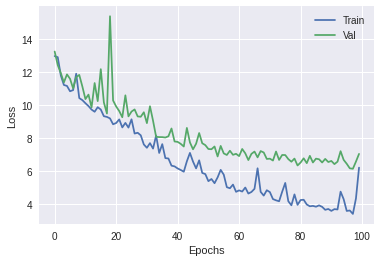

In [16]:
plt.figure()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(flownet_losses["train"])), flownet_losses["train"], label="Train")
plt.plot(range(len(flownet_losses["val"])), flownet_losses["val"], label="Val")
plt.legend()

In [24]:
i = 160
output = model(torch.cat((Tdata[i][0], Tdata[i][1]), dim=0).unsqueeze(dim=0).to(device='cuda'))
img_size = Tdata[i][0].shape[1:]
output = torch.nn.functional.interpolate(output, size=img_size, mode="bilinear", align_corners=False).squeeze()

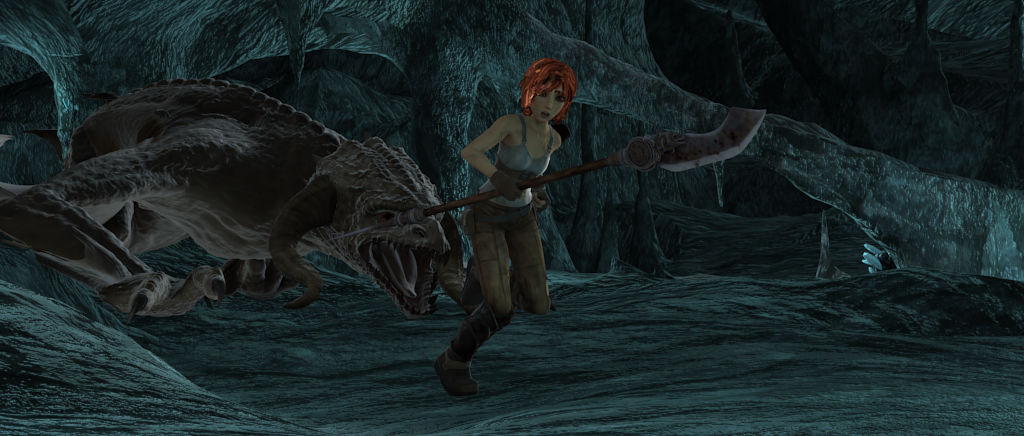

In [25]:
torchvision.transforms.ToPILImage()(Tdata[i][0])

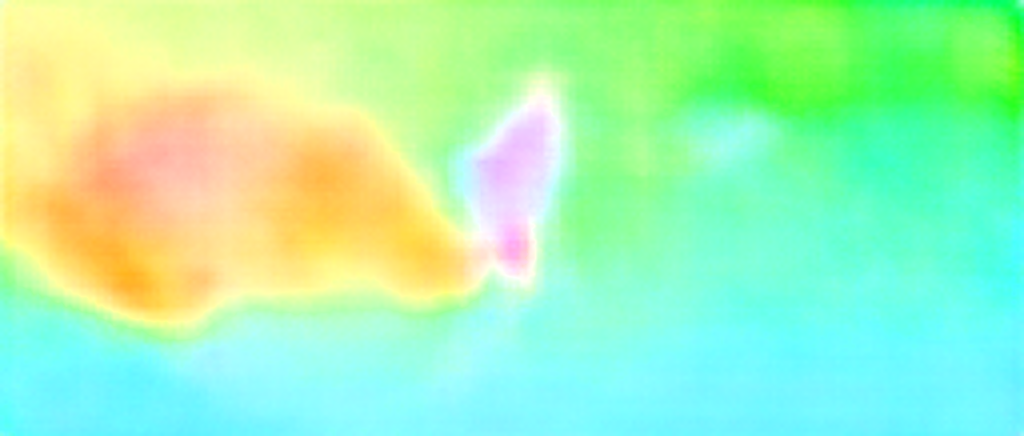

In [26]:
torchvision.transforms.ToPILImage()(torchvision.utils.flow_to_image(output))

In [12]:
from utils import compute_metrics

model = FlowNetS()
model.load_state_dict(torch.load("flownet_sintel.pt"))
model.eval()
val_loader = dataloaders.get("val")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
epe_list = []
one_px = []
three_px = []
five_px = []
f1 = []

for i, (img1, img2, target) in tqdm(enumerate(val_loader)):
    image = torch.cat((img1, img2), dim=1).to(device)
    label = target.to(device)
    output = model(image)
    img_size = Tdata[i][0].shape[1:]
    output = torch.nn.functional.interpolate(output, size=img_size, mode="bilinear", align_corners=False).squeeze()
    metrics, epe = compute_metrics(output, label)
    epe_list.append(metrics['epe'])
    one_px.append(metrics['1px'])
    three_px.append(metrics['3px'])
    five_px.append(metrics['5px'])
    f1.append(metrics['f1'])
    
print("epe: " + str(sum(epe_list) / len(epe_list)))
print("1px: " + str(sum(one_px) / len(epe_list)))
print("3px: " + str(sum(three_px) / len(epe_list)))
print("5px: " + str(sum(five_px) / len(epe_list)))
print("f1: " + str(sum(f1) / len(epe_list)))

26it [00:13,  1.98it/s]

epe: 7.052124816637773
1px: 0.36581063958314747
3px: 0.6872077469642346
5px: 0.7724088682578161
f1: 31.238800459183178
